In [2]:
from zipfile import ZipFile

file_name = "data.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [0]:
import cv2
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from Align import AlignDlib
from tqdm import tqdm
from model import create_model
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from joblib import dump, load
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

from keras.utils import np_utils 
from keras.datasets import mnist 
import seaborn as sns
import tensorflow
from keras.initializers import RandomNormal
from keras.initializers import he_normal
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
import numpy as np
import os.path
import matplotlib.pyplot as plt

import warnings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8, 4]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [0]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

In [0]:
def extensions(path):
    extension = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1]
            extension.append(ext)
    return np.array(extension)

extension = extensions('data')

In [91]:
(pd.Series(extension)).value_counts()

.jpg     551
.jpeg     48
.JPG      18
.png      12
.cms      10
.img       2
dtype: int64

In [0]:
def load_metadata(path):
  metadata = []
  for i in os.listdir(path):
    for f in os.listdir(os.path.join(path, i)):
      ext = os.path.splitext(f)[1]
      if ext == '.jpg' or ext == '.jpeg' or ext=='.JPG' or ext=='.png':
        metadata.append(IdentityMetadata(path, i, f))
  return np.array(metadata)

metadata = load_metadata('data')

In [93]:
len(metadata)

629

In [94]:
metadata[0]

data/john abraham/John_Abraham_Bollywood_d.jpg

In [0]:
names = np.array([m.name for m in metadata])

In [96]:
pd.Series(names).value_counts()[:5]

hrithik roshan                  13
akshay kumar _ Google Search    12
kapil sharma                    11
rajpal yadav                    10
anil kapoor                     10
dtype: int64

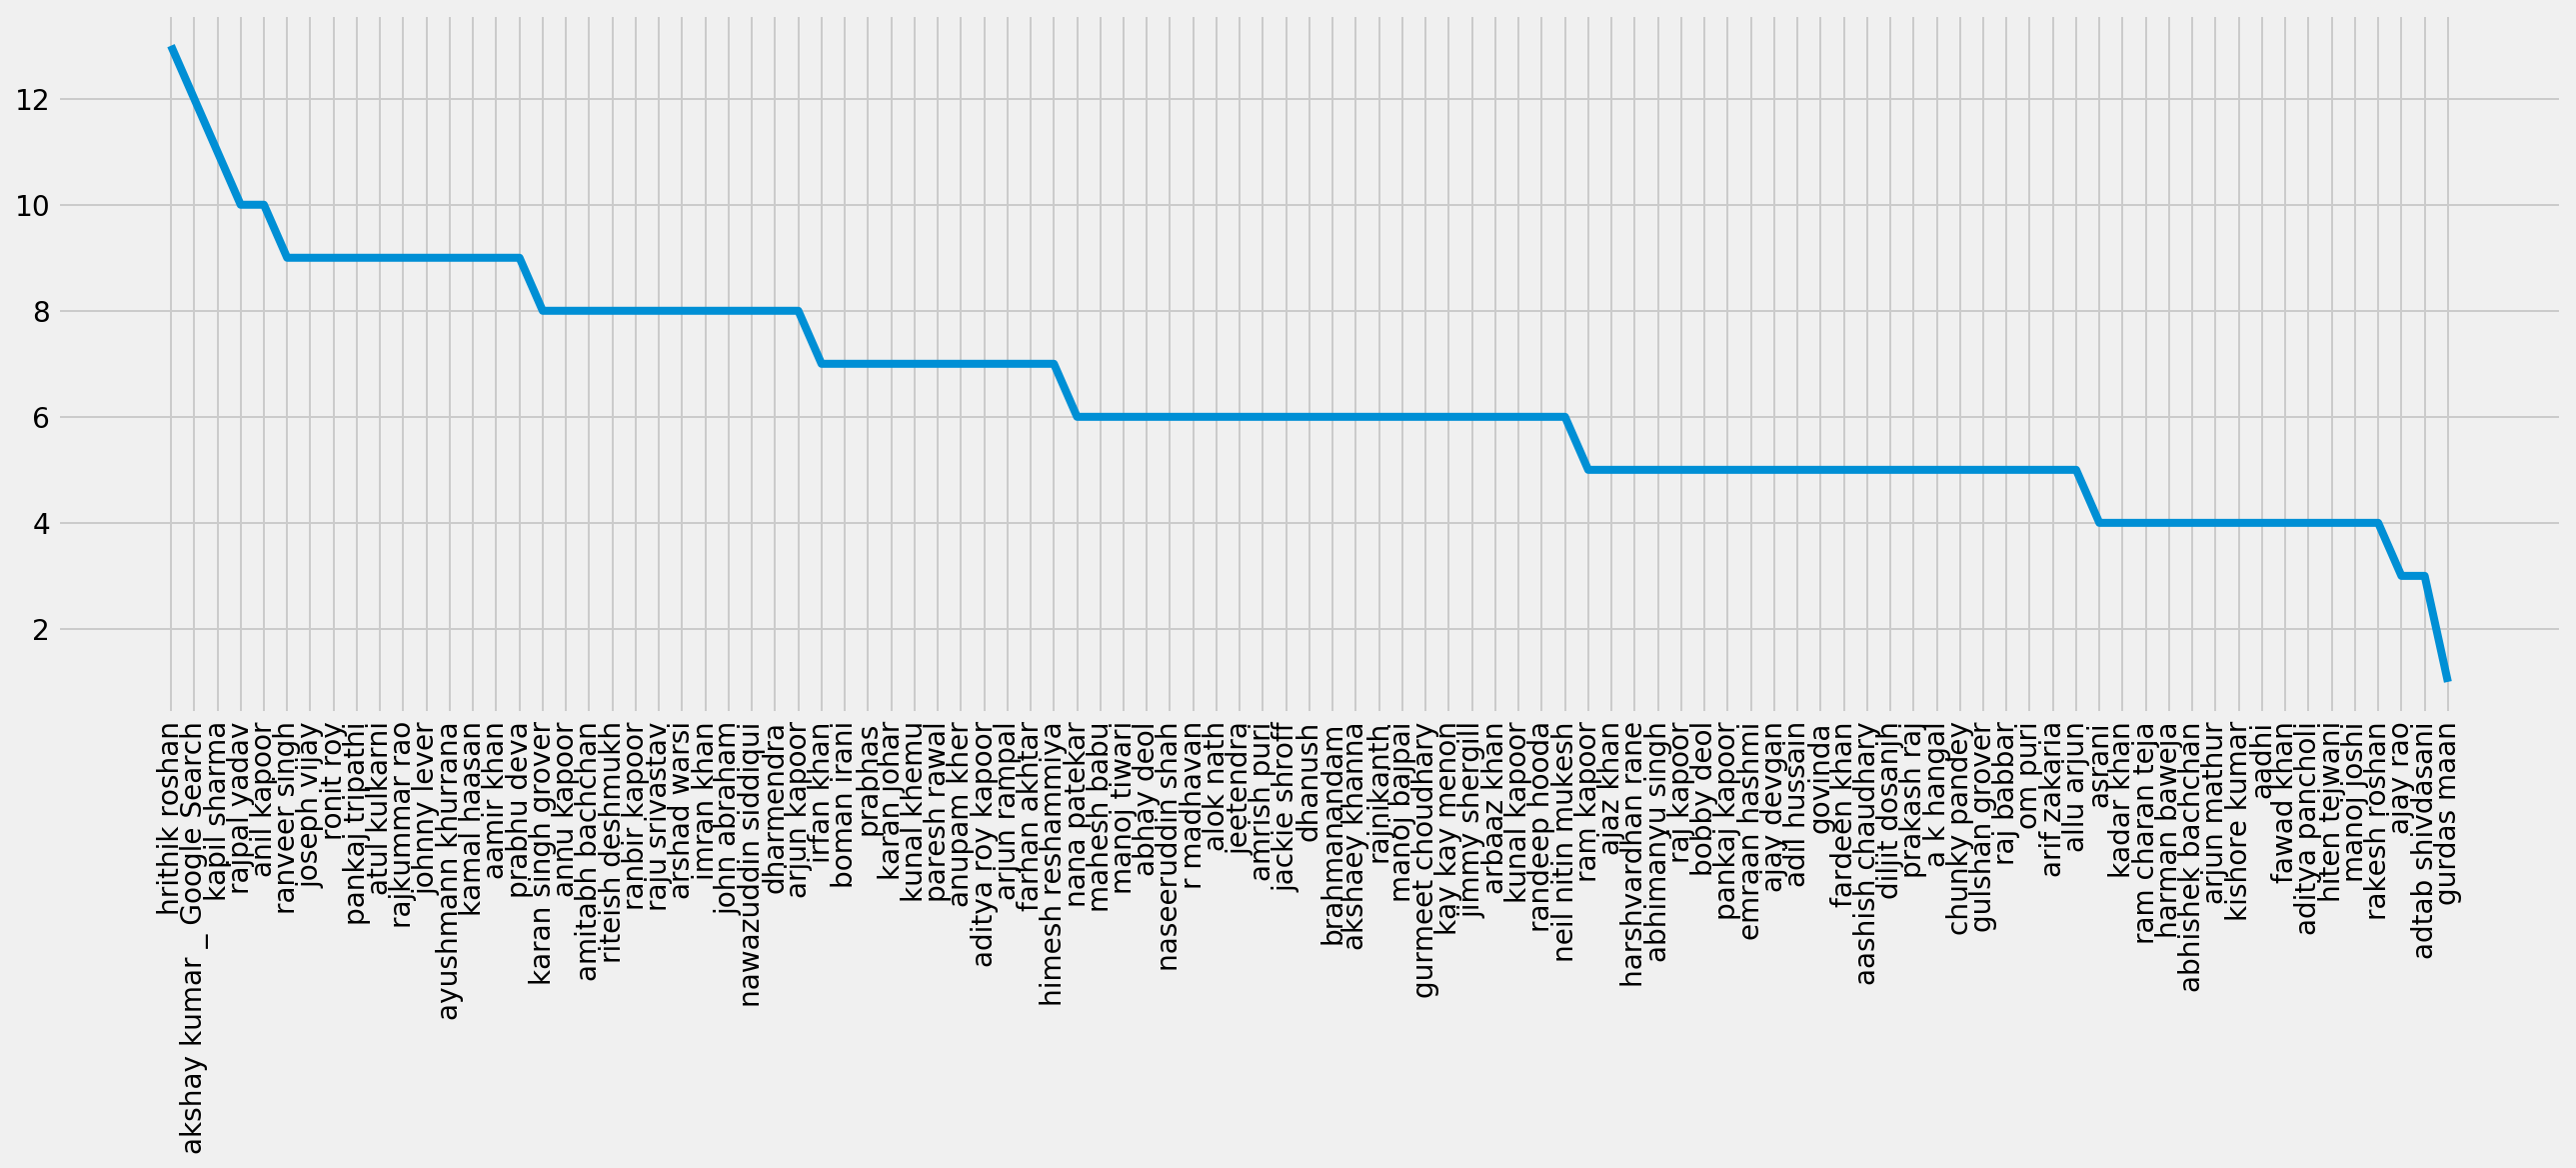

In [97]:
plt.figure(figsize=(20,6))
plt.plot(pd.Series(names).value_counts())
plt.xticks(rotation=90)
plt.grid(b=True)
plt.show()

In [0]:
alignment = AlignDlib('models/landmarks.dat')

In [0]:
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]
  
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [0]:
#Load pretrained Model

model = create_model()
model.load_weights('open_face.h5')

In [101]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in tqdm(enumerate(metadata)):
    try:
      img = load_image(m.image_path())
      img = align_image(img)
      # scale RGB values to interval [0,1]
      img = (img / 255.).astype(np.float32)
      # obtain embedding vector for image
      embedded[i] = model.predict(np.expand_dims(img, axis=0))[0]
    except:
      print(i,m)

629it [03:57,  2.41it/s]


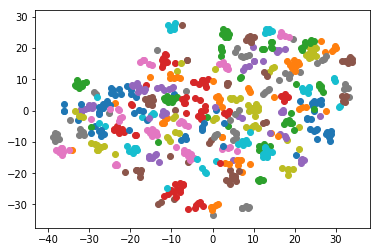

In [15]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(names)):
    idx = names == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   



In [102]:
print("Train data:",(embedded.shape))
print("Output class:",(names.shape))

Train data: (629, 128)
Output class: (629,)


Save 

In [0]:
df = pd.DataFrame(embedded)
df["output"] = names
df.to_csv("embedded_629_celeb.csv",index=False)

### Preparing output label

In [0]:
from sklearn.preprocessing import LabelEncoder

names_encode = LabelEncoder().fit(names)
Y = names_encode.transform(names)

In [0]:
# save
np.save('names_encode.npy', names_encode.classes_)

In [109]:
len(set(names))

99

In [112]:
y = np.zeros((embedded.shape[0],len(set(Y))),dtype=int)
y.shape

(629, 99)

In [0]:
for i,name in enumerate(names):
  ind = Y[i]
  y[i][ind]=1

In [114]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Train Test Split

In [115]:
train_idx = np.arange(embedded.shape[0]) % 5 != 0
test_idx = np.arange(embedded.shape[0]) % 5 == 0

print(np.sum(train_idx))
print(np.sum(test_idx))

503
126


In [0]:
X_train = embedded[train_idx]
y_train = y[train_idx]

X_val = embedded[test_idx]
y_val = y[test_idx]

In [117]:
print(X_train.shape)
print(y_train.shape)

(503, 128)
(503, 99)


In [0]:
output_dim = y_train.shape[1]
input_dim = X_train.shape[1]

batch_size = 8
nb_epoch = 500

In [0]:
import keras

In [120]:
model_relu = Sequential()

model_relu.add(Dense(250, activation='relu', input_shape=(input_dim,), kernel_initializer=keras.initializers.he_normal(seed=None)))
model_relu.add(BatchNormalization())
model_relu.add(Dropout(0.5))

model_relu.add(Dense(100, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=None)) )
model_relu.add(BatchNormalization())
model_relu.add(Dropout(0.5))

model_relu.add(Dense(output_dim,activation='softmax'))

print(model_relu.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 250)               32250     
_________________________________________________________________
batch_normalization_3 (Batch (None, 250)               1000      
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               25100     
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 99)                9999      
Total para

In [0]:
model_relu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [124]:
history = model_relu.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,validation_data=[X_val,y_val])

Train on 503 samples, validate on 126 samples
Epoch 1/500
503/503 [==============================] - 2s 4ms/step - loss: 5.1956 - acc: 0.0159 - val_loss: 4.0461 - val_acc: 0.1349
Epoch 2/500
503/503 [==============================] - 0s 859us/step - loss: 4.4601 - acc: 0.0537 - val_loss: 3.5369 - val_acc: 0.2460
Epoch 3/500
503/503 [==============================] - 0s 873us/step - loss: 3.9318 - acc: 0.1193 - val_loss: 3.0631 - val_acc: 0.3810
Epoch 4/500
503/503 [==============================] - 0s 840us/step - loss: 3.5719 - acc: 0.1590 - val_loss: 2.7704 - val_acc: 0.4524
Epoch 5/500
503/503 [==============================] - 0s 864us/step - loss: 3.2261 - acc: 0.2505 - val_loss: 2.5284 - val_acc: 0.4841
Epoch 6/500
503/503 [==============================] - 0s 845us/step - loss: 2.9593 - acc: 0.2883 - val_loss: 2.3007 - val_acc: 0.5635
Epoch 7/500
503/503 [==============================] - 0s 880us/step - loss: 2.8378 - acc: 0.3320 - val_loss: 2.0928 - val_acc: 0.6190
Epoch 8/500

### Plot

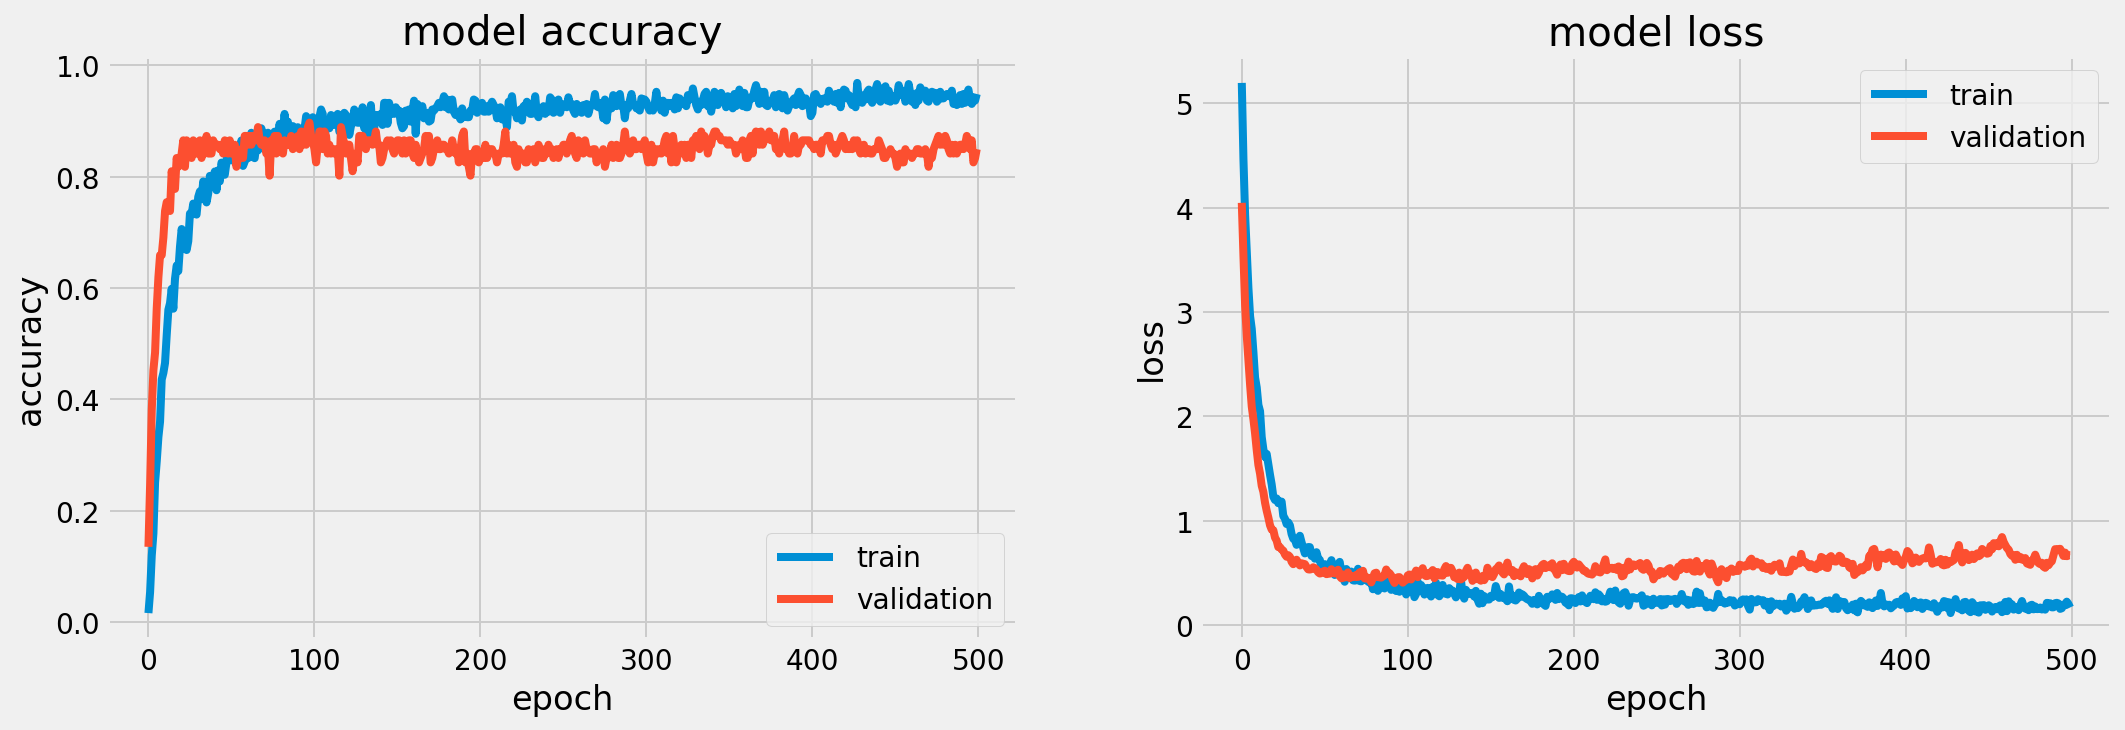

In [125]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

In [126]:
# serialize model to JSON
model_json = model_relu.to_json()
with open("sequential_NN_629_model_output_53dim.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_relu.save_weights("sequential_NN_629_model_ouput_53dim.h5")

print("Saved model to disk")

Saved model to disk


## Testing the model

Original Query Image


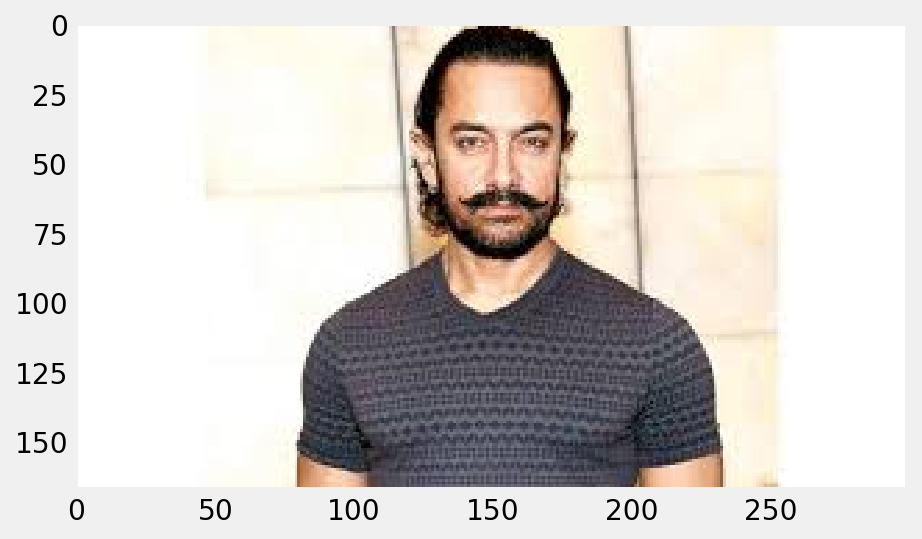

In [127]:
path = "download (4).jpg"
img = load_image(path)
print("Original Query Image")
plt.imshow(img)
plt.grid(b=None)

In [128]:
faces = alignment.getAllFaceBoundingBoxes(img)
faces

rectangles[[(129, 26) (181, 78)]]

In [129]:
for i in range(len(faces)):
  face_aligned = alignment.align(96, img, faces[i], landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
  face_aligned = (face_aligned / 255.).astype(np.float32)
  embedding = model.predict(np.expand_dims(face_aligned, axis=0))[0]
  pred = model_relu.predict([[embedding]])
  ind = np.argsort(pred[0])
  print(ind[::-1][:5])
  print("Prediction: ",le.inverse_transform([ind[::-1][0]])[0])
  print("Prediction Probability: ",pred[0][ind[::-1][0]]*100,"%")
  print()

[ 2 86 72  5 93]
Prediction:  aamir khan
Prediction Probability:  99.85066056251526 %

